In [1]:
import sys

assert sys.version_info >= (3, 7)

In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [4]:
df = pd.read_csv('/content/PriceBTC9_1h.csv')

In [5]:
df.head(2)

,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2021-04-30 04:00:00+00:00,53693.988281,54194.015625,53693.988281,54114.515625,0,0.0,0.0
1,2021-04-30 05:00:00+00:00,54132.265625,54309.980469,53940.894531,54309.980469,0,0.0,0.0


In [6]:
df = df.sort_values("Datetime").set_index("Datetime")
df.head(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2021-04-30 04:00:00+00:00,53693.988281,54194.015625,53693.988281,54114.515625,0,0.0,0.0
2021-04-30 05:00:00+00:00,54132.265625,54309.980469,53940.894531,54309.980469,0,0.0,0.0


In [7]:
import pandas as pd
import tensorflow as tf

# Assuming df is your DataFrame and DateTime is already the index
stock_train = df["Open"][:"2021-07-26 01:00:00+00:00"]
stock_valid = df["Open"]["2021-07-26 01:00:00+00:00":"2021-08-16 18:00:00+00:00"]
stock_test = df["Open"]["2021-08-16 18:00:00+00:00":"2021-09-07 10:00:00+00:00"]

# Convert the Series to Numpy arrays
train_data = stock_train.values /50000
valid_data = stock_valid.values/50000
test_data = stock_test.values/50000

# 2. Creating Time Series Dataset

# Define the parameters
sequence_length = 150  # This is the length of the sequences (timesteps)
batch_size = 80  # Number of samples per batch

# Creating time series datasets from the data arrays
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    data=train_data,
    targets=train_data[sequence_length:],
    sequence_length=sequence_length,
    batch_size=batch_size
)

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    data=valid_data,
    targets=valid_data[sequence_length:],
    sequence_length=sequence_length,
    batch_size=batch_size
)

# 3. Model Fitting and Evaluation

tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[sequence_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=5, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=200,
                    callbacks=[early_stopping_cb])



Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.6975 - mae: 1.1109 - val_loss: 0.1019 - val_mae: 0.4499
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0592 - mae: 0.2740 - val_loss: 0.0090 - val_mae: 0.1270
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0205 - mae: 0.1778 - val_loss: 0.0081 - val_mae: 0.1208
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0080 - mae: 0.1134 - val_loss: 0.0031 - val_mae: 0.0694
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0051 - mae: 0.0855 - val_loss: 0.0034 - val_mae: 0.0747
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0053 - mae: 0.0876 - val_loss: 0.0032 - val_mae: 0.0722
Epoch 7/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0047 - mae: 0.0829 - val_loss: 0.0028 - val_mae: 0.0672
Epoch 8/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0042 - mae: 0.0779 - val_loss: 0.0025 - val_mae: 0.0637
Epoch 9/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0038 -

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9674e-04 - mae: 0.0157 
Scaled MAE: 824.0685798227787


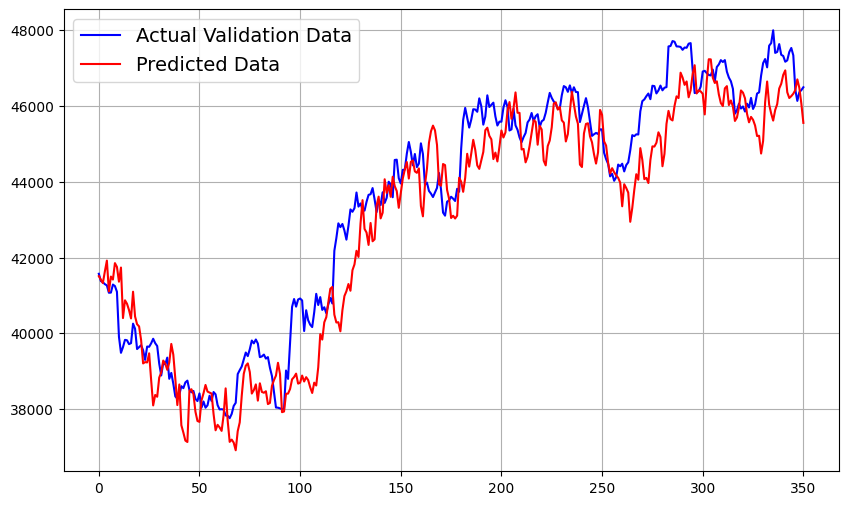

In [8]:
pred_values = model.predict(valid_ds)
plt.figure(figsize=(10, 6))
plt.plot(stock_valid[150:].to_numpy(), label="Actual Validation Data", color="blue")
plt.plot(pred_values*50000, label="Predicted Data", color="red")
plt.grid('on')
plt.legend()
# Get the loss and mae from the validation set
valid_loss, valid_mae = model.evaluate(valid_ds)

# Multiply the MAE by 40,000
scaled_mae = valid_mae * 50000

print(f"Scaled MAE: {scaled_mae}")
plt.show()

In [17]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=200):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=8, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 50000

#Simple RNN

In [18]:

tf.random.set_seed(42)  # extra code – ensures reproducibility
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

In [19]:
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.005)

Epoch 1/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0334 - mae: 0.2428 - val_loss: 0.0205 - val_mae: 0.2007
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0229 - mae: 0.1924 - val_loss: 0.0121 - val_mae: 0.1528
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0159 - mae: 0.1501 - val_loss: 0.0079 - val_mae: 0.1219
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0124 - mae: 0.1234 - val_loss: 0.0057 - val_mae: 0.1025
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0106 - mae: 0.1070 - val_loss: 0.0045 - val_mae: 0.0899
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0096 - mae: 0.0977 - val_loss: 0.0038 - val_mae: 0.0814
Epoch 7/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0090 - mae: 0.0925 - val_loss: 0.0034 - val_mae: 0.0756
Epoch 8/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0087 - mae: 0.0896 - val_loss: 0.0031 - val_mae: 0.0715
Epoch 9/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - lo

2603.810466825962

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0011 - mae: 0.0386    
Scaled MAE: 2603.810466825962


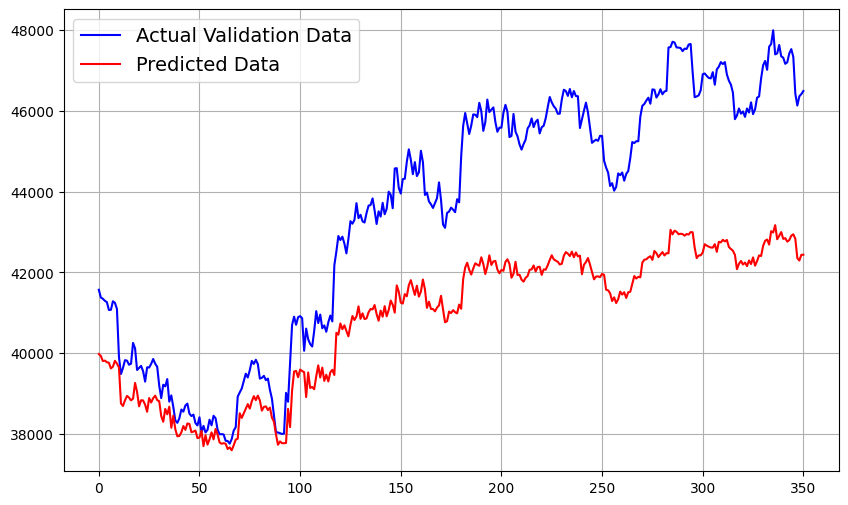

In [20]:
pred_values = model.predict(valid_ds)
plt.figure(figsize=(10, 6))
plt.plot(stock_valid[150:].to_numpy(), label="Actual Validation Data", color="blue")
plt.plot(pred_values*50000, label="Predicted Data", color="red")
plt.grid('on')
plt.legend()
# Get the loss and mae from the validation set
valid_loss, valid_mae = model.evaluate(valid_ds)

# Multiply the MAE by 50,000
scaled_mae = valid_mae * 50000

print(f"Scaled MAE: {scaled_mae}")
plt.show()

#More Neurons RNN

In [21]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
more_n_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)  # no activation function by default
])

In [ ]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(more_n_model, train_ds, valid_ds, learning_rate=0.005)

Epoch 1/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.2456 - mae: 0.5563 - val_loss: 0.0261 - val_mae: 0.2228
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0390 - mae: 0.2443 - val_loss: 0.0200 - val_mae: 0.1945
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0300 - mae: 0.2117 - val_loss: 0.0228 - val_mae: 0.2088
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0285 - mae: 0.2030 - val_loss: 0.0228 - val_mae: 0.2098
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0259 - mae: 0.1910 - val_loss: 0.0206 - val_mae: 0.1996
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0223 - mae: 0.1753 - val_loss: 0.0173 - val_mae: 0.1831
Epoch 7/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0184 - mae: 0.1580 - val_loss: 0.0139 - val_mae: 0.1639
Epoch 8/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0148 - mae: 0.1408 - val_loss: 0.0108 - val_mae: 0.1445
Epoch 9/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - lo

382.4209328740835

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.8233e-05 - mae: 0.0075
Scaled MAE: 382.4209328740835


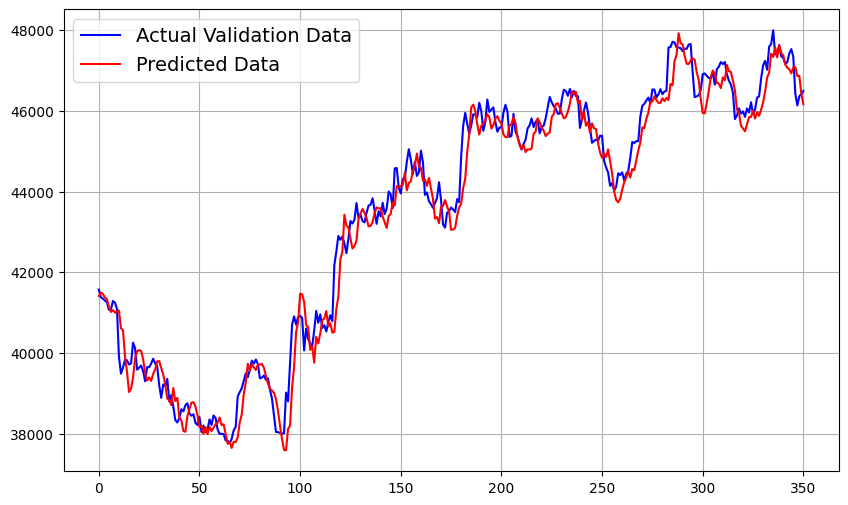

In [ ]:
pred_values = more_n_model.predict(valid_ds)
plt.figure(figsize=(10, 6))
plt.plot(stock_valid[150:].to_numpy(), label="Actual Validation Data", color="blue")
plt.plot(pred_values*50000, label="Predicted Data", color="red")
plt.grid('on')
plt.legend()
# Get the loss and mae from the validation set
valid_loss, valid_mae = more_n_model.evaluate(valid_ds)

# Multiply the MAE by 50,000
scaled_mae = valid_mae * 50000

print(f"Scaled MAE: {scaled_mae}")
plt.show()

#Deep RNNs

In [22]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [23]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.005)

Epoch 1/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - loss: 0.2620 - mae: 0.5832 - val_loss: 0.0167 - val_mae: 0.1730
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0561 - mae: 0.2941 - val_loss: 0.0447 - val_mae: 0.2929
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0526 - mae: 0.2723 - val_loss: 0.0089 - val_mae: 0.1204
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - loss: 0.0264 - mae: 0.2000 - val_loss: 0.0124 - val_mae: 0.1472
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 0.0282 - mae: 0.2048 - val_loss: 0.0107 - val_mae: 0.1357
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0260 - mae: 0.1975 - val_loss: 0.0102 - val_mae: 0.1329
Epoch 7/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0247 - mae: 0.1925 - val_loss: 0.0098 - val_mae: 0.1299
Epoch 8/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0235 - mae: 0.1877 - val_loss: 0.0093 - val_mae: 0.1269
Epoch 9/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step

430.4945468902588

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 6.3432e-05 - mae: 0.0083
Scaled MAE: 430.4945468902588


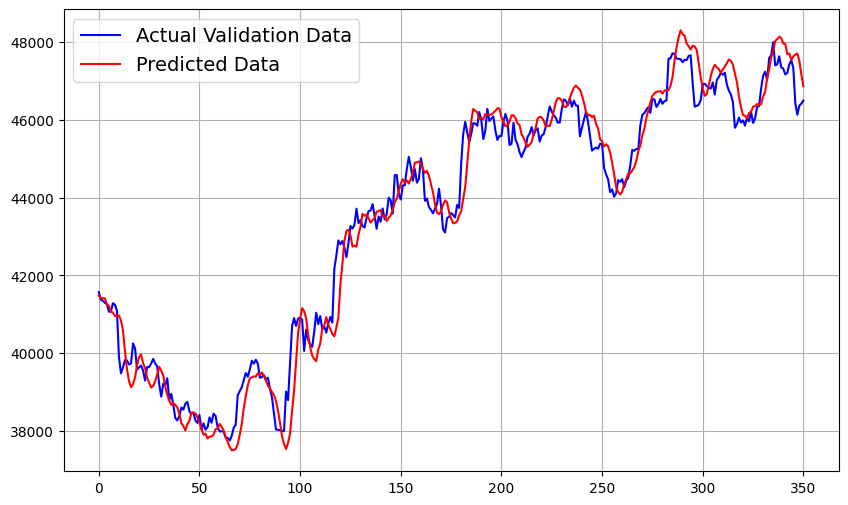

In [24]:
pred_values = deep_model.predict(valid_ds)
plt.figure(figsize=(10, 6))
plt.plot(stock_valid[150:].to_numpy(), label="Actual Validation Data", color="blue")
plt.plot(pred_values*50000, label="Predicted Data", color="red")
plt.grid('on')
plt.legend()
# Get the loss and mae from the validation set
valid_loss, valid_mae = deep_model.evaluate(valid_ds)

# Multiply the MAE by 50,000
scaled_mae = valid_mae * 50000

print(f"Scaled MAE: {scaled_mae}")
plt.show()

# Multivariate time series

In [26]:
df_mulvar = df[["Open", "High","Low"]] / 50000  # use both bus & rail series as input
df_mulvar.head(3)

,Open,High,Low
Datetime,,,
2021-04-30 04:00:00+00:00,1.073880,1.083880,1.073880
2021-04-30 05:00:00+00:00,1.082645,1.086200,1.078818
2021-04-30 06:00:00+00:00,1.085184,1.088574,1.083750


In [27]:
# Assuming df is your DataFrame and DateTime is already the index
stock_train = df_mulvar[:"2021-07-26 01:00:00+00:00"]
stock_valid = df_mulvar["2021-07-26 01:00:00+00:00":"2021-08-16 18:00:00+00:00"]
stock_test = df_mulvar["2021-08-16 18:00:00+00:00":"2021-09-07 10:00:00+00:00"]


In [28]:
stock_train.head(3)

,Open,High,Low
Datetime,,,
2021-04-30 04:00:00+00:00,1.073880,1.083880,1.073880
2021-04-30 05:00:00+00:00,1.082645,1.086200,1.078818
2021-04-30 06:00:00+00:00,1.085184,1.088574,1.083750


In [29]:
# Define the parameters
sequence_length = 150  # This is the length of the sequences (timesteps)
batch_size = 80  # Number of samples per batch

# Creating time series datasets from the data arrays
train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    data=stock_train.to_numpy(),
    targets=stock_train["Open"][sequence_length:],
    sequence_length=sequence_length,
    batch_size=batch_size
)

valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    data=stock_valid.to_numpy(),
    targets=stock_valid["Open"][sequence_length:],
    sequence_length=sequence_length,
    batch_size=batch_size
)


In [30]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 3]),
    tf.keras.layers.Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds,
                 learning_rate=0.005)

Epoch 1/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0982 - mae: 0.3700 - val_loss: 0.0035 - val_mae: 0.0808
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0025 - mae: 0.0569 - val_loss: 0.0015 - val_mae: 0.0478
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0049 - mae: 0.0844 - val_loss: 0.0024 - val_mae: 0.0666
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0047 - mae: 0.0832 - val_loss: 0.0018 - val_mae: 0.0572
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0031 - mae: 0.0680 - val_loss: 0.0012 - val_mae: 0.0464
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0020 - mae: 0.0541 - val_loss: 7.8985e-04 - val_mae: 0.0376
Epoch 7/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0013 - mae: 0.0431 - val_loss: 5.3282e-04 - val_mae: 0.0305
Epoch 8/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 8.1981e-04 - mae: 0.0345 - val_loss: 3.6601e-04 - val_mae: 0.0249
Epoch 9/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 2

458.360742777586

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.1357e-05 - mae: 0.0092
Scaled MAE: 458.360742777586


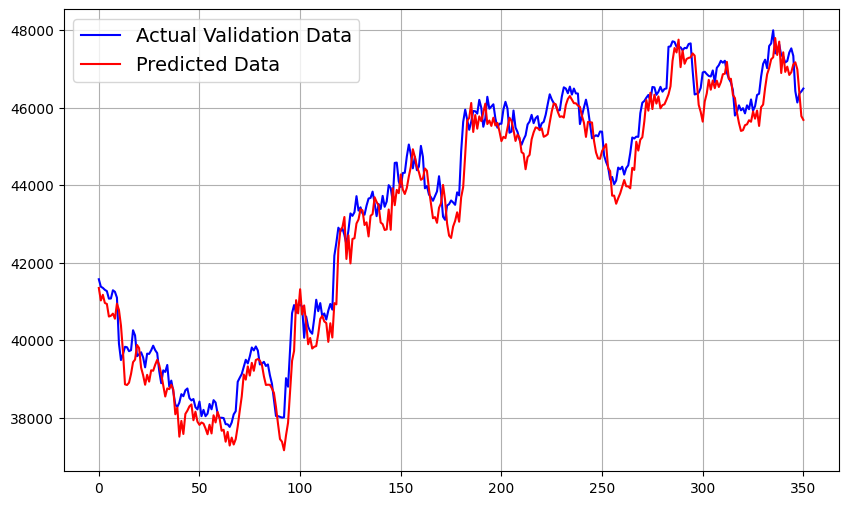

In [ ]:
pred_values = mulvar_model.predict(valid_mulvar_ds)
plt.figure(figsize=(10, 6))
plt.plot(stock_valid["Open"][150:].to_numpy()*50000, label="Actual Validation Data", color="blue")
plt.plot(pred_values*50000, label="Predicted Data", color="red")
plt.grid('on')
plt.legend()
# Get the loss and mae from the validation set
valid_loss, valid_mae = mulvar_model.evaluate(valid_mulvar_ds)

# Multiply the MAE by 50,000
scaled_mae = valid_mae * 50000

print(f"Scaled MAE: {scaled_mae}")
plt.show()